In [1]:
#Importing necessary libraries
import zipfile
import cv2
import random
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from os import listdir
from collections import Counter
from google.colab import drive

import numpy as np
import scipy as sp
import seaborn as sns
import sklearn.cluster
from scipy.spatial.distance import cdist, pdist
from numpy import linalg
import pylab as pl
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def ssq_statistics(data, ks=range(1,11), ssq_norm=True):
    """Computes the sum of squares for an nxm dataset.

    The sum of squares (SSQ) is a measure of within-cluster variation that measures the sum of 
    squared distances from cluster prototypes.

    Each computation of the SSQ requires the clustering of the input dataset. To identify the 
    optimal number of clusters k, the SSQ is computed over a range of possible values of k 
    (via the parameter ks). For each value of k, within-cluster dispersion is calculated for the 
    input dataset.

    The estimated optimal number of clusters, then, is defined as the value of k prior to an
    "elbow" point in the plot of SSQ values.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      ssqs: an array of SSQs, one computed for each k.

    """
    ssqs = sp.zeros((len(ks),)) # array for SSQs (lenth ks)

    #n_samples, n_features = data.shape # the number of rows (samples) and columns (features)
    #if n_samples >= 2500:
    #    # Generate a small sub-sample of the data
    #    data_sample = shuffle(data, random_state=0)[:1000]
    #else:
    #    data_sample = data

    for (i,k) in enumerate(ks): # iterate over the range of k values        
        # Fit the model on the data
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(data)

        # Predict on the data (k-means) and get labels
        #labels = kmeans.predict(data)

        if ssq_norm:
            dist = np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)

            tot_withinss = sum(dist**2) # Total within-cluster sum of squares
            totss = sum(pdist(data)**2) / data.shape[0] # The total sum of squares
            betweenss = totss - tot_withinss # The between-cluster sum of squares
            ssqs[i] = betweenss/totss*100
        else:
            # The sum of squared error (SSQ) for k
            ssqs[i] = kmeans.inertia_

    return ssqs

In [3]:
def plot_ssq_statistics(ssqs):
    """Generates and shows plots for the sum of squares (SSQ).

    A figure with one plot is generated. The plot is a bar plot of the SSQ computed for each 
    value of k.

    Args:
      ssqs (SciPy array): An array of SSQs, one computed for each k.

    """
    # Create a figure
    fig = pl.figure(figsize=(6.75, 4))

    ind = range(1,len(ssqs)+1) # the x values for the ssqs
    width = 0.5 # the width of the bars

    # Create a bar plot
    #rects = pl.bar(ind, ssqs, width)
    pl.plot(ind, ssqs)

    # Add figure labels and ticks
    pl.title('Clustering Sum of Squared Distances', fontsize=16)
    pl.xlabel('Number of clusters k', fontsize=14)
    pl.ylabel('Sum of Squared Distance (SSQ)', fontsize=14)
    pl.xticks(ind)

    # Add text labels
    #for rect in rects:
    #    height = rect.get_height()
    #    pl.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d' % int(height), \
    #            ha='center', va='bottom')

    # Add figure bounds
    pl.ylim(0, max(ssqs)*1.2)
    pl.xlim(0, len(ssqs)+1.0)

    pl.show()

In [4]:
dst = sp.spatial.distance.euclidean

def gap_statistics(data, refs=None, nrefs=20, ks=range(1,11)):
    """Computes the gap statistics for an nxm dataset.

    The gap statistic measures the difference between within-cluster dispersion on an input
    dataset and that expected under an appropriate reference null distribution.

    Computation of the gap statistic, then, requires a series of reference (null) distributions.
    One may either input a precomputed set of reference distributions (via the parameter refs)
    or specify the number of reference distributions (via the parameter nrefs) for automatic 
    generation of uniform distributions within the bounding box of the dataset (data).

    Each computation of the gap statistic requires the clustering of the input dataset and of
    several reference distributions. To identify the optimal number of clusters k, the gap 
    statistic is computed over a range of possible values of k (via the parameter ks).

    For each value of k, within-cluster dispersion is calculated for the input dataset and each
    reference distribution. The calculation of the within-cluster dispersion for the reference
    distributions will have a degree of variation, which we measure by standard deviation or
    standard error.

    The estimated optimal number of clusters, then, is defined as the smallest value k such that
    gap_k is greater than or equal to the sum of gap_k+1 minus the expected error err_k+1.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      refs ((n,m,k) SciPy array, optional): A precomputed set of reference distributions. 
        Defaults to None.
      nrefs (int, optional): The number of reference distributions for automatic generation. 
        Defaults to 20.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      gaps: an array of gap statistics computed for each k.
      errs: an array of standard errors (se), with one corresponding to each gap computation.
      difs: an array of differences between each gap_k and the sum of gap_k+1 minus err_k+1.

    """
    shape = data.shape

    if refs==None:
        tops = data.max(axis=0) # maxima along the first axis (rows)
        bots = data.min(axis=0) # minima along the first axis (rows)
        dists = sp.matrix(sp.diag(tops-bots)) # the bounding box of the input dataset

        # Generate nrefs uniform distributions each in the half-open interval [0.0, 1.0)
        rands = sp.random.random_sample(size=(shape[0],shape[1], nrefs))

        # Adjust each of the uniform distributions to the bounding box of the input dataset
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = sp.zeros((len(ks),))   # array for gap statistics (lenth ks)
    errs = sp.zeros((len(ks),))   # array for model standard errors (length ks)
    difs = sp.zeros((len(ks)-1,)) # array for differences between gaps (length ks-1)

    for (i,k) in enumerate(ks): # iterate over the range of k values
        # Cluster the input dataset via k-means clustering using the current value of k
        try:
            (kmc,kml) = sp.cluster.vq.kmeans2(data, k)
        except np.linalg.LinAlgError:
            kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(data)
            (kmc, kml) = kmeans.cluster_centers_, kmeans.labels_

        # Generate within-dispersion measure for the clustering of the input dataset
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])

        # Generate within-dispersion measures for the clusterings of the reference datasets
        refdisps = sp.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            # Cluster the reference dataset via k-means clustering using the current value of k
            try:
                (kmc,kml) = sp.cluster.vq.kmeans2(rands[:,:,j], k)
            except np.linalg.LinAlgError:
                kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(rands[:,:,j])
                (kmc, kml) = kmeans.cluster_centers_, kmeans.labels_

            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])

        # Compute the (estimated) gap statistic for k
        gaps[i] = sp.mean(sp.log(refdisps) - sp.log(disp))

        # Compute the expected error for k
        errs[i] = sp.sqrt(sum(((sp.log(refdisp)-sp.mean(sp.log(refdisps)))**2) \
                              for refdisp in refdisps)/float(nrefs)) * sp.sqrt(1+1/nrefs)

    # Compute the difference between gap_k and the sum of gap_k+1 minus err_k+1
    difs = sp.array([gaps[k] - (gaps[k+1]-errs[k+1]) for k in range(len(gaps)-1)])

    #print "Gaps: " + str(gaps)
    #print "Errs: " + str(errs)
    #print "Difs: " + str(difs)

    return gaps, errs, difs

In [5]:
def plot_gap_statistics(gaps, errs, difs):
    """Generates and shows plots for the gap statistics.

    A figure with two subplots is generated. The first subplot is an errorbar plot of the 
    estimated gap statistics computed for each value of k. The second subplot is a barplot 
    of the differences in the computed gap statistics.

    Args:
      gaps (SciPy array): An array of gap statistics, one computed for each k.
      errs (SciPy array): An array of standard errors (se), with one corresponding to each gap 
        computation.
      difs (SciPy array): An array of differences between each gap_k and the sum of gap_k+1 
        minus err_k+1.

    """
    # Create a figure
    fig = pl.figure(figsize=(16, 4))

    pl.subplots_adjust(wspace=0.35) # adjust the distance between figures

    # Subplot 1
    ax = fig.add_subplot(121)
    ind = range(1,len(gaps)+1) # the x values for the gaps

    # Create an errorbar plot
    rects = ax.errorbar(ind, gaps, yerr=errs, xerr=None, linewidth=1.0)

    # Add figure labels and ticks
    ax.set_title('Clustering Gap Statistics', fontsize=16)
    ax.set_xlabel('Number of clusters k', fontsize=14)
    ax.set_ylabel('Gap Statistic', fontsize=14)
    ax.set_xticks(ind)

    # Add figure bounds
    ax.set_ylim(0, max(gaps+errs)*1.1)
    ax.set_xlim(0, len(gaps)+1.0)

    # Subplot 2
    ax = fig.add_subplot(122)
    ind = range(1,len(difs)+1) # the x values for the difs
    
    max_gap = None
    if len(np.where(difs > 0)[0]) > 0:
        max_gap = np.where(difs > 0)[0][0] + 1 # the k with the first positive dif

    # Create a bar plot
    ax.bar(ind, difs, alpha=0.5, color='g', align='center')

    # Add figure labels and ticks
    if max_gap:
        ax.set_title('Clustering Gap Differences\n(k=%d Estimated as Optimal)' % (max_gap), \
                     fontsize=16)
    else:
        ax.set_title('Clustering Gap Differences\n', fontsize=16)
    ax.set_xlabel('Number of clusters k', fontsize=14)
    ax.set_ylabel('Gap Difference', fontsize=14)
    ax.xaxis.set_ticks(range(1,len(difs)+1))

    # Add figure bounds
    ax.set_ylim(min(difs)*1.2, max(difs)*1.2)
    ax.set_xlim(0, len(difs)+1.0)

    # Show the figure
    pl.show()

In [6]:
data = pd.read_csv('/content/drive/MyDrive/DataMining/shopping-data.csv')
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
data.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [8]:
df = data[['Spending Score (1-100)', 'Annual Income (k$)']]
df

,Spending Score (1-100),Annual Income (k$)
0,39,15
1,81,15
2,6,16
3,77,16
4,40,17
...,...,...
195,79,120
196,28,126
197,74,126
198,18,137


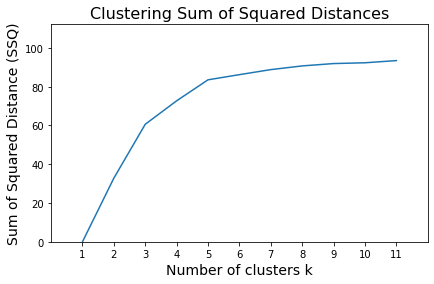

In [9]:
ssqs = ssq_statistics(df , ks=range(1,11+1))
plot_ssq_statistics(ssqs)

In [10]:
df.columns
X=df.iloc[:, [0,1]].values
X = X.astype(float)

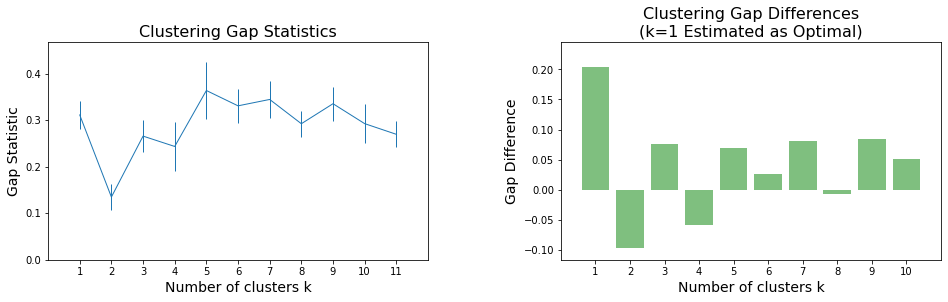

In [11]:
# Generate and plot the gap statistics
gaps, errs, difs = gap_statistics(X, nrefs =20, ks=range(1, 11+1))
plot_gap_statistics(gaps, errs , difs)

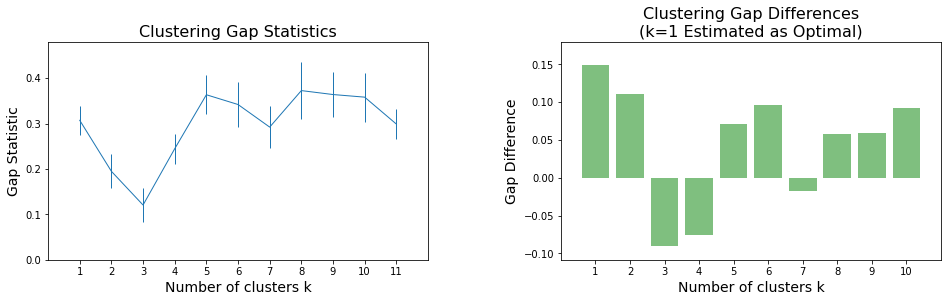

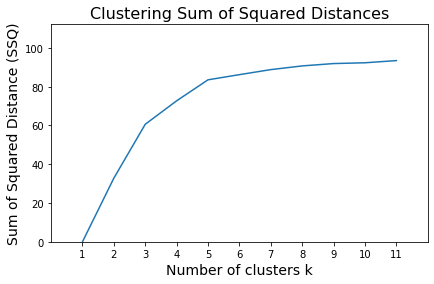

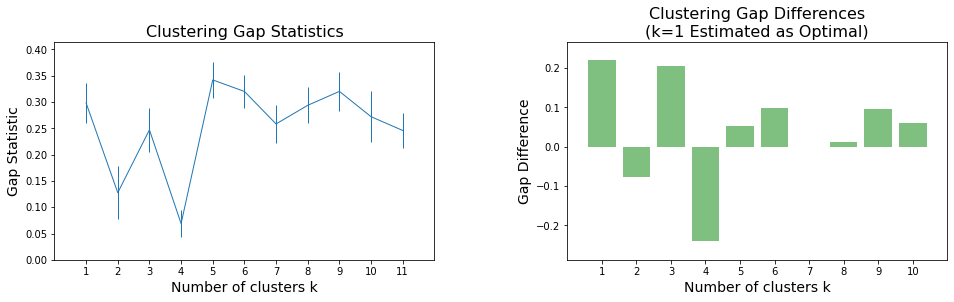

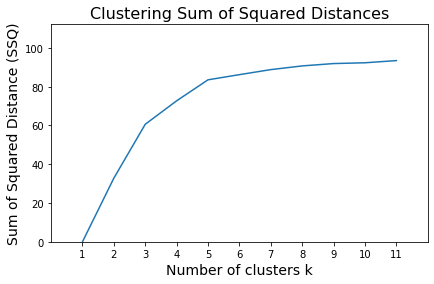

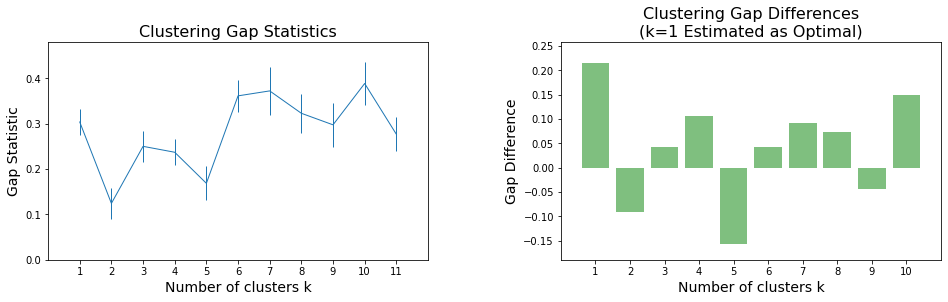

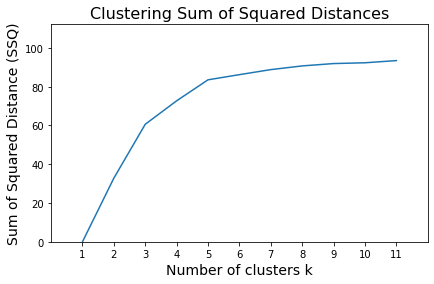

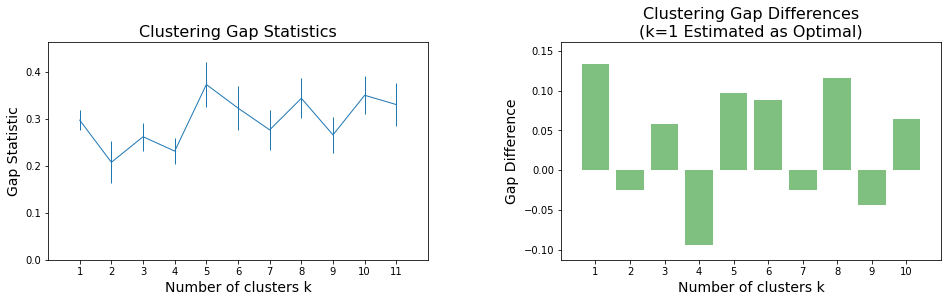

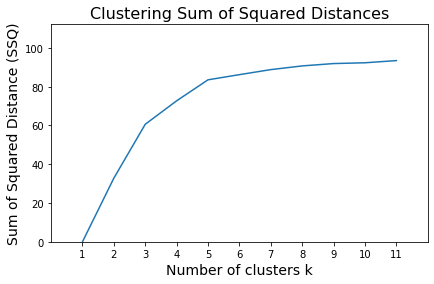

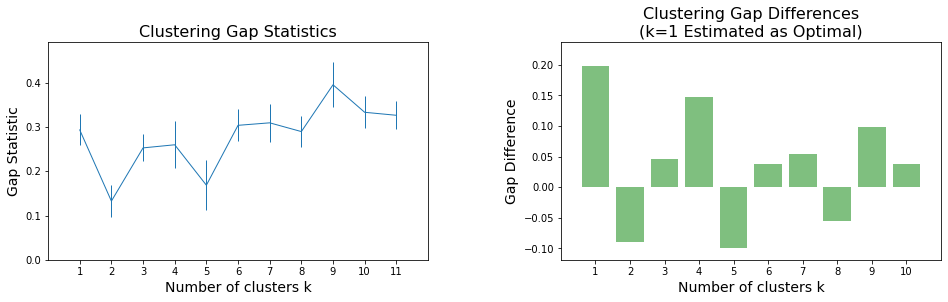

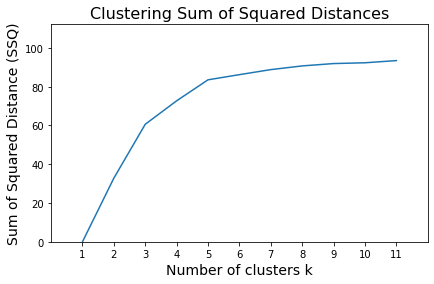

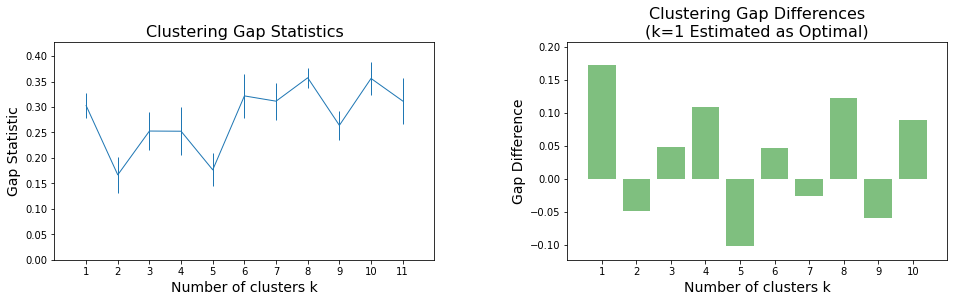

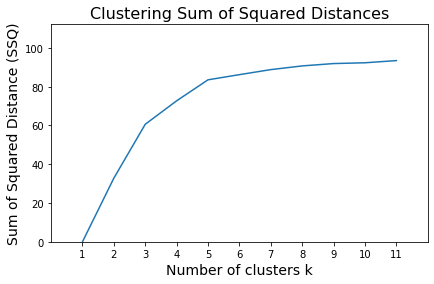

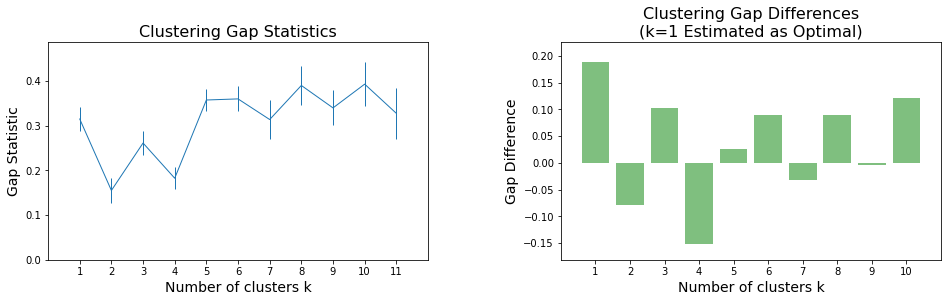

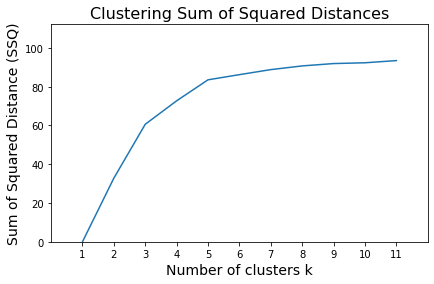

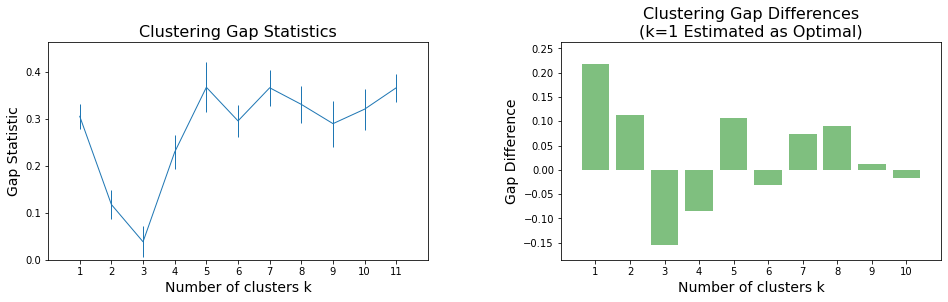

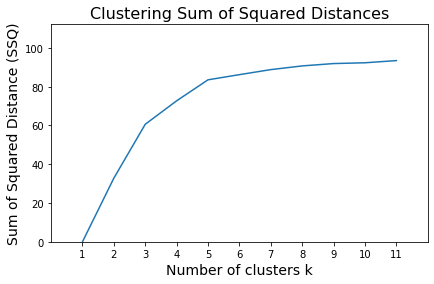

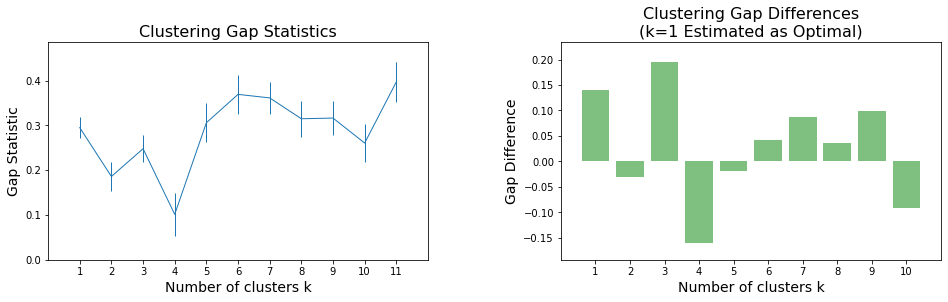

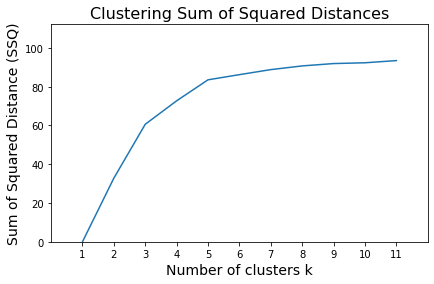

In [12]:
for i in range(9):
    n_clusters = 11

    gaps, errs, difs = gap_statistics(X, nrefs=20, ks=range(1,n_clusters+1))
    plot_gap_statistics(gaps, errs, difs)

    ssqs = ssq_statistics(df, ks=range(1,n_clusters+1))
    plot_ssq_statistics(ssqs)

    # Find best k
    max_gap = None
    if len(np.where(difs > 0)[0]) > 0:
        max_gap = np.where(difs > 0)[0][0] + 1 # the k with the first positive dif

    # Fit the model on the data
    if max_gap:
        kmeans = KMeans(n_clusters=max_gap, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
        y_kmeans = kmeans.fit_predict(df)
        y_kmeans = kmeans.predict(X)
        ''' kmeans = sklearn.cluster.KMeans(n_clusters=max_gap, random_state=0).fit(data)
        labels = kmeans.predict(data) '''

In [13]:
kmeans = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_kmeans = kmeans.fit_predict(df)

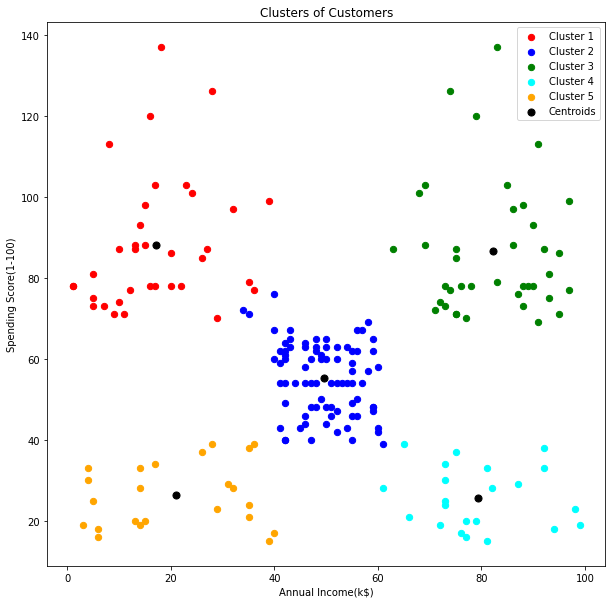

In [14]:
fig = pl.figure(figsize=(10, 10))
plt.scatter(x = X[y_kmeans==0, 0], y = X[y_kmeans==0, 1], s=40, c='red', label ='Cluster 1')
plt.scatter(x = X[y_kmeans==1, 0], y = X[y_kmeans==1, 1], s=40, c='blue', label ='Cluster 2')
plt.scatter(x = X[y_kmeans==2, 0], y = X[y_kmeans==2, 1], s=40, c='green', label ='Cluster 3')
plt.scatter(x = X[y_kmeans==3, 0], y = X[y_kmeans==3, 1], s=40, c='cyan', label ='Cluster 4')
plt.scatter(x = X[y_kmeans==4, 0], y = X[y_kmeans==4, 1], s=40, c='orange', label ='Cluster 5')

plt.scatter(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1], s=50, c='black', label = 'Centroids')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100)')
plt.legend(loc="upper right")
plt.show()

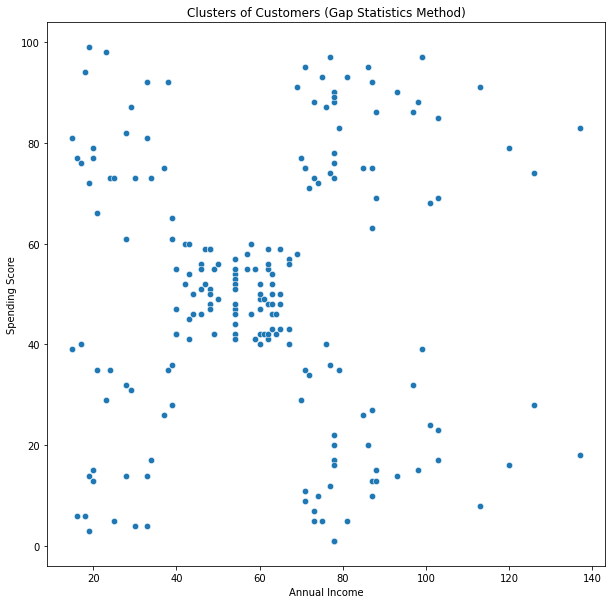

In [15]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data = df, x = 'Annual Income (k$)', y = 'Spending Score (1-100)', s = 40)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Clusters of Customers (Gap Statistics Method)')
plt.show()

1. Where did you estimate the elbow point to be (between what values of k)? What value
of k was typically estimated as optimal by the gap statistic? To adequately answer this
question, consider generating both measures several (atleast 5) times, as there may be
some amount of variation in the value of k that they each estimate as optimal.

The elbow point that we got in case of the SSQ method is between the value of k = 3 to k = 5. By generating the measure for about 9 times, the optimal value of k from the Gap Statistics method is 1. 
 
The optimal value when it comes to the gap statistics method i.e. k = 1 does not seem to make any sense. This implies that no clusters can be made and there exist no segmentations for this data. However, considering the SSQ method, the value of k = 5 does seem to fit in since it implies that there exist boundaries that help us form 5 different clusters. So, for further analysis, we will consider the SSQ method as the optimal method. 


2. Based on the scatter plot of the clustered data, what makes most sense? Give logical
interpretation from visually inspecting the clusters.

Based on the scatter plot of the clustered data for the two methods: SSQ and Gap Statistics, it can be interpreted that the optimal value of k is very different in both the instances. From the Gap Statistics method, the value of k = 1 implies that there are no clusters at all. However, the value of k = 5 derived from the SSQ method seems ideal as we can clearly distinguish 5 different clusters and their centroids. So, we can understand that, 5 different annual income clusters can be identified for certain ranges of spending scores. 

3. Between SSQ and Gap Statistics, does one measure seem to be a consistently better
criterion for choosing the value of k than the other? Why or why not?

Gap statistics measures how different the total within intra-cluster variation can be between observed data and reference data with a random uniform distribution. A large gap statistics means the clustering structure is very far away from the random uniform distribution of points. There's an underestimation of clusters that occurs in case of Gap statistics since it always shows k = 1. 

The sum of squares is a measure of the variability of the observations within each cluster. And based on the distinct clustering done with this method, it does seem as though the SSQ method is a consistently better criterion for choosing the value of k than the Gap statistics method.

## Converting to PDF

In [ ]:
!sudo apt update

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [20]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/DataMining/DataMiningAssignmentFive.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/DataMining/DataMiningAssignmentFive.ipynb to pdf
[NbConvertApp] Support files will be in DataMiningAssignmentFive_files/
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMiningAssignmentFive_files
[NbConvertApp] Making directory ./DataMin